In [134]:
import torch
from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import TorchData
import uuid

In [135]:
import importlib
importlib.reload(TorchData)

<module 'TorchData' from 'F:\\projects\\ResearchProject\\TorchData\\__init__.py'>

In [3]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [48]:
X=88
Y=128
T_OFFSET=100
NUM_DATA=16384
SIGNAL_COUNT_MIN=20
SIGNAL_COUNT_MAX=30
SIGNAL_SELECT_MODE="retain"
NOISE_DENSITY=0.01
NOISE_MAGNITUDE=1.0
BLUR_LEVEL=1
DISPERSION_LEVEL=1.0
MODE="normal"

BATCH_SIZE=512
EPOCH=3000
MULTI_GPU=True

model_name = "HybridTransformer"

In [29]:
train_dataset = TorchData.TORCHData(x=X, y=Y, num_data=NUM_DATA,
                                    signal_count=(SIGNAL_COUNT_MIN, SIGNAL_COUNT_MAX), signal_select_mode=SIGNAL_SELECT_MODE,
                                    noise_density=NOISE_DENSITY, t_offset=T_OFFSET,
                                    blur_level=BLUR_LEVEL, dispersion_level=DISPERSION_LEVEL, mode=MODE)
train_dataloader = train_dataset.dataloader(batch_size=BATCH_SIZE, shuffle=True)

KeyboardInterrupt: 

In [49]:
test_dataset = TorchData.TORCHData(x=X, y=Y, num_data=1024,
                                   signal_count=(SIGNAL_COUNT_MIN, SIGNAL_COUNT_MAX), signal_select_mode=SIGNAL_SELECT_MODE,
                                   noise_density=NOISE_DENSITY, t_offset=T_OFFSET,
                                   blur_level=BLUR_LEVEL, dispersion_level=DISPERSION_LEVEL, mode=MODE)
test_dataloader = test_dataset.dataloader(batch_size=BATCH_SIZE, shuffle=False)

In [31]:
class LearnablePositionalEncoding(torch.nn.Module):
    def __init__(self, embed_dim=64, max_seq_length=X*Y*4/64):
        super().__init__()
        self.pos_embed = torch.nn.Parameter(
            torch.zeros(1, int(max_seq_length), embed_dim),
            requires_grad=True
        )
        torch.nn.init.normal_(self.pos_embed, std=0.02)  # Xavier-style initialization

    def forward(self, x):
        B, seq, embed_size = x.shape
        return x + self.pos_embed[:, :seq]

In [32]:
class HybridTransformer(torch.nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_layers=2):
        super().__init__()

        # CNN Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.GELU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.GELU(),
            torch.nn.MaxPool2d(2)
        )

        # Transformer
        self.transformer = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=4*embed_dim,
                batch_first=True,
                norm_first=True,  # Better stability
                dropout=0.1
            ),
            num_layers=num_layers
        )


        # CNN Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.GELU(),
            torch.nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.GELU(),
            torch.nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
        )

        # self.pos_embed = torch.nn.Parameter(torch.randn(1, 690, embed_dim))
        self.learnable_position_embed = LearnablePositionalEncoding(embed_dim)
        # self.fixed_pos_embed = PositionalEncoding(embed_dim)

    def forward(self, x):
        # Encoder
        cnn_features = self.encoder(x)  # [B, 64, H/4, W/4]

        # Transformer processing
        B, C, H, W = cnn_features.shape
        x = cnn_features.flatten(2).permute(0, 2, 1)

        # x = x + self.pos_embed[:, :H*W, :]
        # x = self.fixed_pos_embed(x)
        x = self.learnable_position_embed(x)
        x = self.transformer(x)

        # Feature fusion
        x = x.permute(0, 2, 1).view(B, C, H, W)
        x = x + cnn_features  # Residual connection

        # Decoder pathway
        return self.decoder(x)

In [33]:
model = HybridTransformer()
if MULTI_GPU:
    model = torch.nn.DataParallel(model)
model = model.to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

F:\projects\ResearchProject\venv\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [56]:
summary(model, input_size=(16, 1, Y, X))

Layer (type:depth-idx)                             Output Shape              Param #
DataParallel                                       [16, 1, 128, 88]          --
├─HybridTransformer: 1-1                           [16, 1, 128, 88]          --
│    └─Sequential: 2-1                             [16, 64, 32, 22]          --
│    │    └─Conv2d: 3-1                            [16, 32, 128, 88]         320
│    │    └─BatchNorm2d: 3-2                       [16, 32, 128, 88]         64
│    │    └─GELU: 3-3                              [16, 32, 128, 88]         --
│    │    └─MaxPool2d: 3-4                         [16, 32, 64, 44]          --
│    │    └─Conv2d: 3-5                            [16, 64, 64, 44]          18,496
│    │    └─BatchNorm2d: 3-6                       [16, 64, 64, 44]          128
│    │    └─GELU: 3-7                              [16, 64, 64, 44]          --
│    │    └─MaxPool2d: 3-8                         [16, 64, 32, 22]          --
│    └─LearnablePositionalEnc

In [57]:
scalar = torch.amp.GradScaler()

for epoch in tqdm(range(EPOCH)):
    for x, y in train_dataloader:
        optimiser.zero_grad()

        with torch.amp.autocast(device):
            outputs = model(x.to(device))
            loss = loss_function(outputs, y.to(device))

        scalar.scale(loss).backward()
        scalar.step(optimiser)
        scalar.update()

100%|██████████| 3000/3000 [49:04<00:00,  1.02it/s]


In [59]:
uid = uuid.uuid4()
file_name = f"{model_name}_{uid}.pth"
torch.save(model.state_dict(), f"{file_name}")

In [142]:
### Using pretrained weights
model.load_state_dict(torch.load(f"../ModelWeights/HybridTransformer/HybridTransformerV2_d5370bfd-247c-4d00-ab12-c2f721615db7.pth"))

<All keys matched successfully>

In [143]:
model.eval()
with torch.no_grad():
    pred = model(test_dataset.input_data.to(device)).to("cpu")

pred = test_dataset.input_data * (pred > 1)
test_dataset.predict_data = pred

(<Figure size 1400x400 with 4 Axes>,
 array([[<Axes: title={'center': 'Signal'}, xlabel='X', ylabel='Y'>,
         <Axes: >, <Axes: >]], dtype=object))

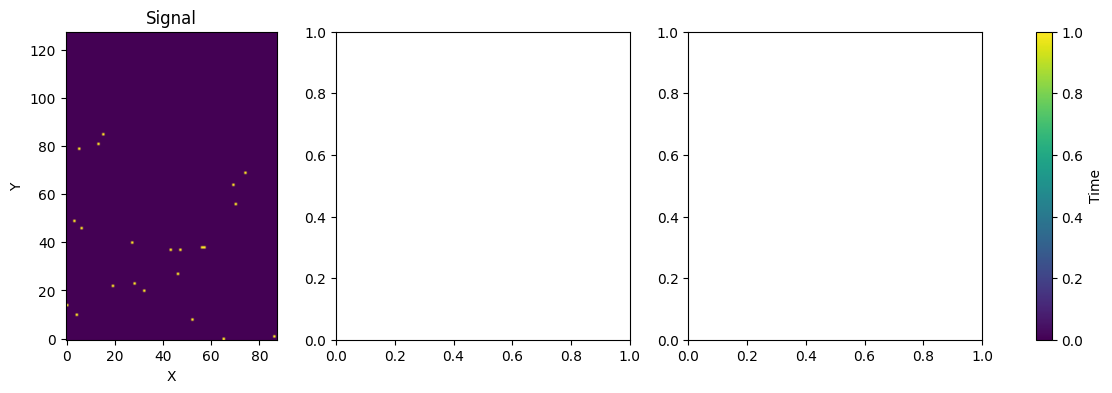

In [147]:
TorchData.plot2d_f(test_dataset, ["signal"], index=0)

(<Figure size 1400x400 with 4 Axes>,
 array([[<Axes: title={'center': 'Input Data'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 'Target Data'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 'Predict Data'}, xlabel='X', ylabel='Y'>]],
       dtype=object))

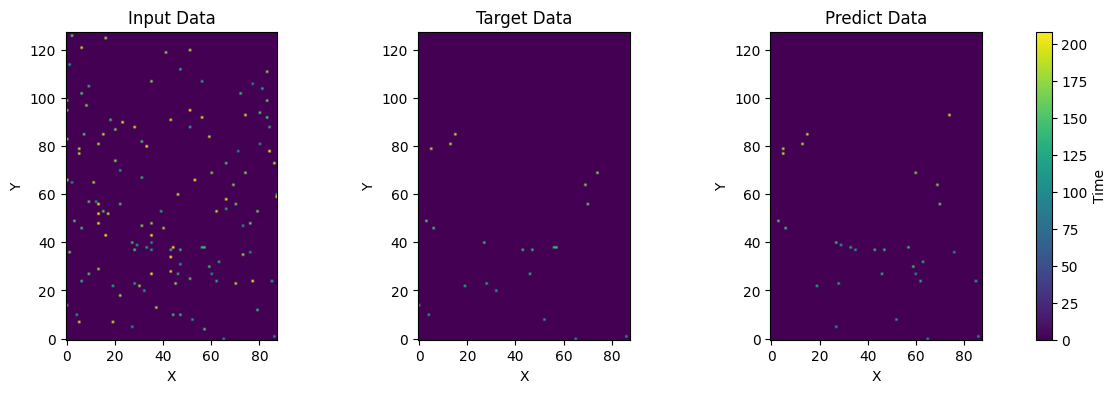

In [144]:
TorchData.plot2d_f(test_dataset, ["input_data", "target_data", "predict_data"], index=0)

(<Figure size 1500x600 with 4 Axes>,
 array([[<Axes3D: title={'center': 'Input Data'}, xlabel='X', ylabel='Y', zlabel='Time'>,
         <Axes3D: title={'center': 'Target Data'}, xlabel='X', ylabel='Y', zlabel='Time'>,
         <Axes3D: title={'center': 'Predict Data'}, xlabel='X', ylabel='Y', zlabel='Time'>]],
       dtype=object))

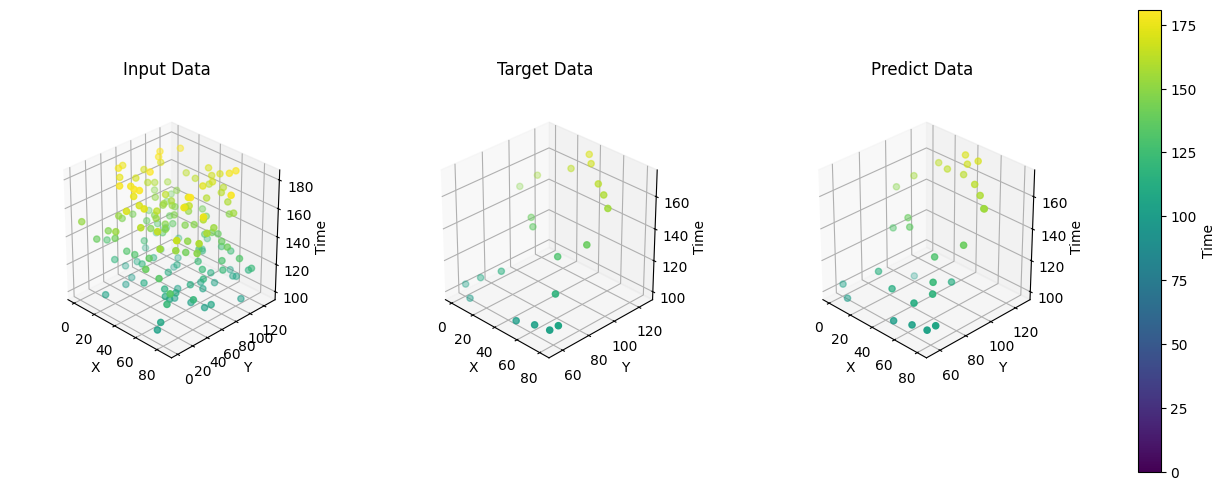

In [145]:
TorchData.visual.plot3d_f(test_dataset, ["input_data", "target_data", "predict_data"], index=2)

In [146]:
TorchData.get_metrics(test_dataset.target_data, test_dataset.predict_data)

{'MSE': 18.63504981994629,
 'PSNR': 34.417213439941406,
 'SSIM': 0.9649729132652283,
 'ROC AUC': np.float64(0.9469513643750933),
 'F1': 0.8116528202885877}